In [1]:
!pip install scanpy igraph

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy as sc

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = "./write/paul15.h5ad"
# low dpi (dots per inch) yields small inline figures
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")

In [4]:
adata = sc.datasets.paul15()

In [5]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

In [6]:
# this is not required and results will be comparable without it
adata.X = adata.X.astype("float64")

###Preprocessing and Visualization

In [7]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_recipes.py:185: FutureWarning: Use sc.pp.highly_variable_genes instead
  filter_result = filter_genes_dispersion(


    finished (0:00:00)


In [8]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:00)


In [9]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:12)


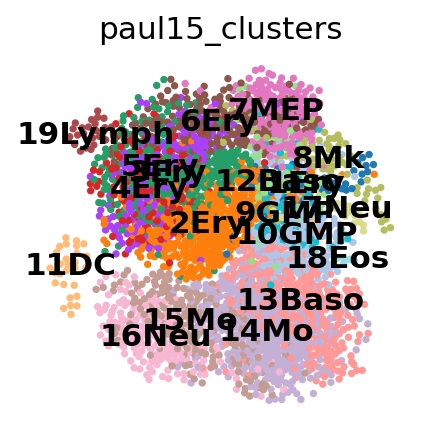

In [10]:
sc.pl.draw_graph(adata, color="paul15_clusters", legend_loc="on data")

### Denoising the graph

In [11]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_diffmap")

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989278  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.98398703 0.983007   0.9790806  0.9762548
     0.9744365  0.9729161  0.9652972 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [12]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:12)


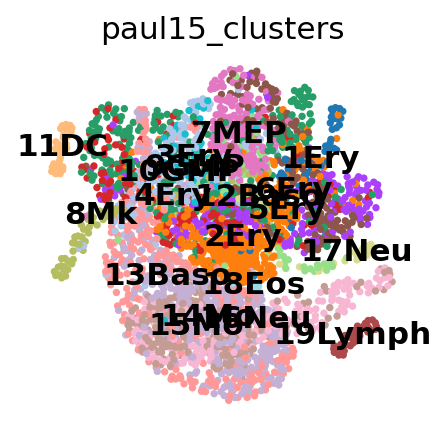

In [13]:
sc.pl.draw_graph(adata, color="paul15_clusters", legend_loc="on data")

### Clustering and PAGA

In [19]:
!pip install leidenalg

In [20]:
sc.tl.leiden(adata, resolution=1.0)

running Leiden clustering


/tmp/ipython-input-1432200975.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0)


    finished: found 33 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Annotate the clusters using marker genes.

| Cell Type            | Marker(s)                                                                 |
|---------------------|---------------------------------------------------------------------------|
| HSCs                | Procr                                                                     |
| Erythroids          | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1                             |
| Neutrophils         | Elane, Cebpe, Ctsg, Mpo, Gfi1                                             |
| Monocytes           | Irf8, Csf1r, Ctsg, Mpo                                                   |
| Megakaryocytes      | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf                            |
| Basophils           | Mcpt8, Prss34                                                             |
| B cells             | Cd19, Vpreb2, Cd79a                                                      |
| Mast cells          | Cma1, Gzmb, CD117/C-Kit                                                  |
| Mast cells & Basophils | Ms4a2, Fcer1a, Cpa3, CD203c (human)                                    |

For simple, coarse-grained visualization, compute the **PAGA graph**, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse-grained graph are thresholded away.


In [22]:
sc.tl.paga(adata, groups="leiden")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


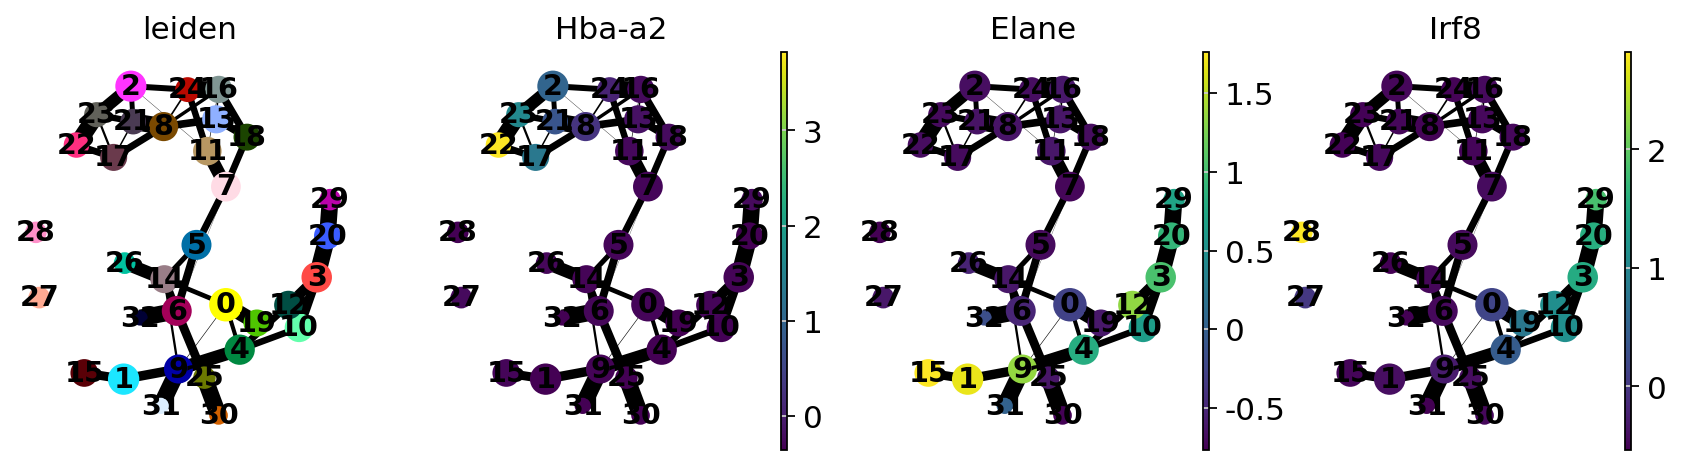

In [23]:
sc.pl.paga(adata, color=["leiden", "Hba-a2", "Elane", "Irf8"])

--> added 'pos', the PAGA positions (adata.uns['paga'])


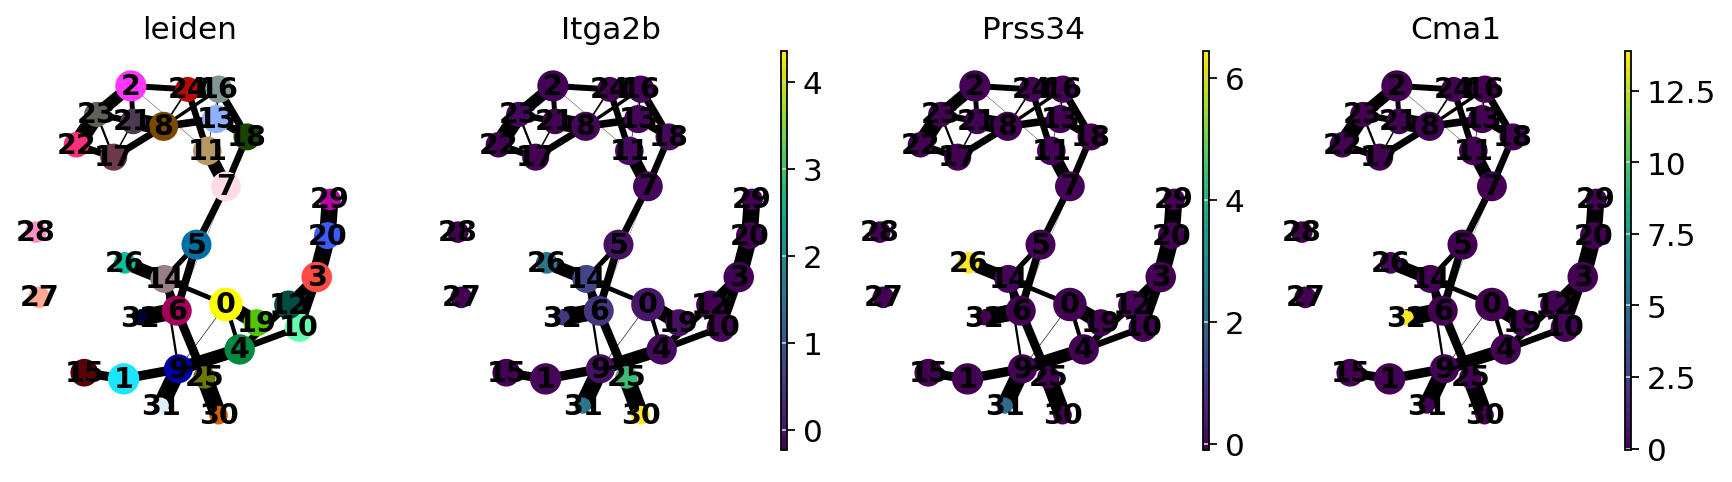

In [24]:
sc.pl.paga(adata, color=["leiden", "Itga2b", "Prss34", "Cma1"])

--> added 'pos', the PAGA positions (adata.uns['paga'])


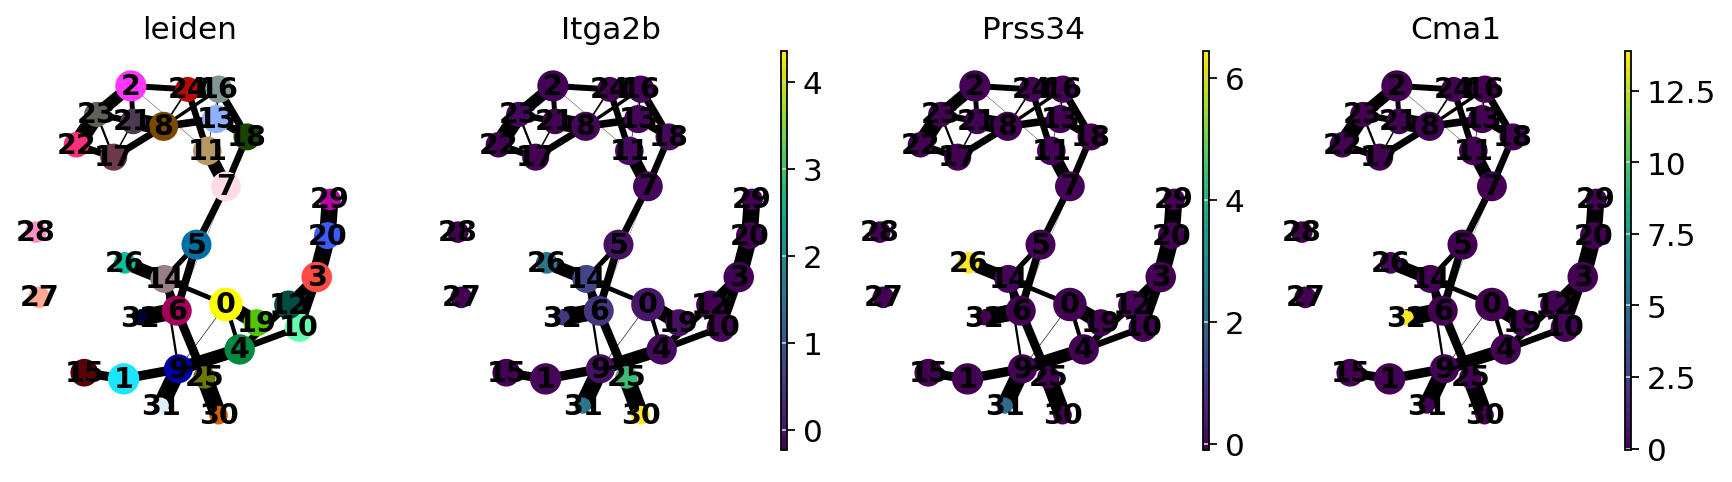

In [25]:
sc.pl.paga(adata, color=["leiden", "Itga2b", "Prss34", "Cma1"])

In [26]:
adata.obs["leiden"].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32'],
      dtype='object')

In [27]:
adata.obs["leiden_anno"] = adata.obs["leiden"].cat.rename_categories(
    {
        "10": "10/Ery",
        "16": "16/Stem",
        "19": "19/Neu",
        "20": "20/Mk",
        "22": "22/Baso",
        "24": "24/Mo",
    }
)

In [28]:
sc.tl.paga(adata, groups="leiden_anno")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


<Axes: >

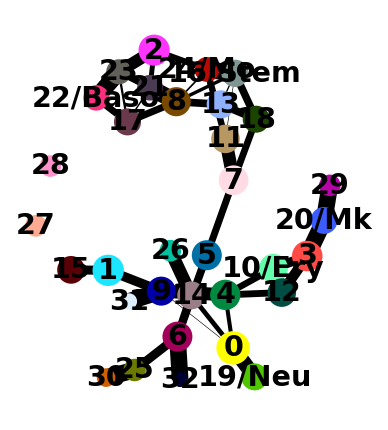

In [29]:
sc.pl.paga(adata, threshold=0.03, show=False)

### Recomputing the embedding using PAGA-initialization

In [30]:
sc.tl.draw_graph(adata, init_pos="paga")

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:03)


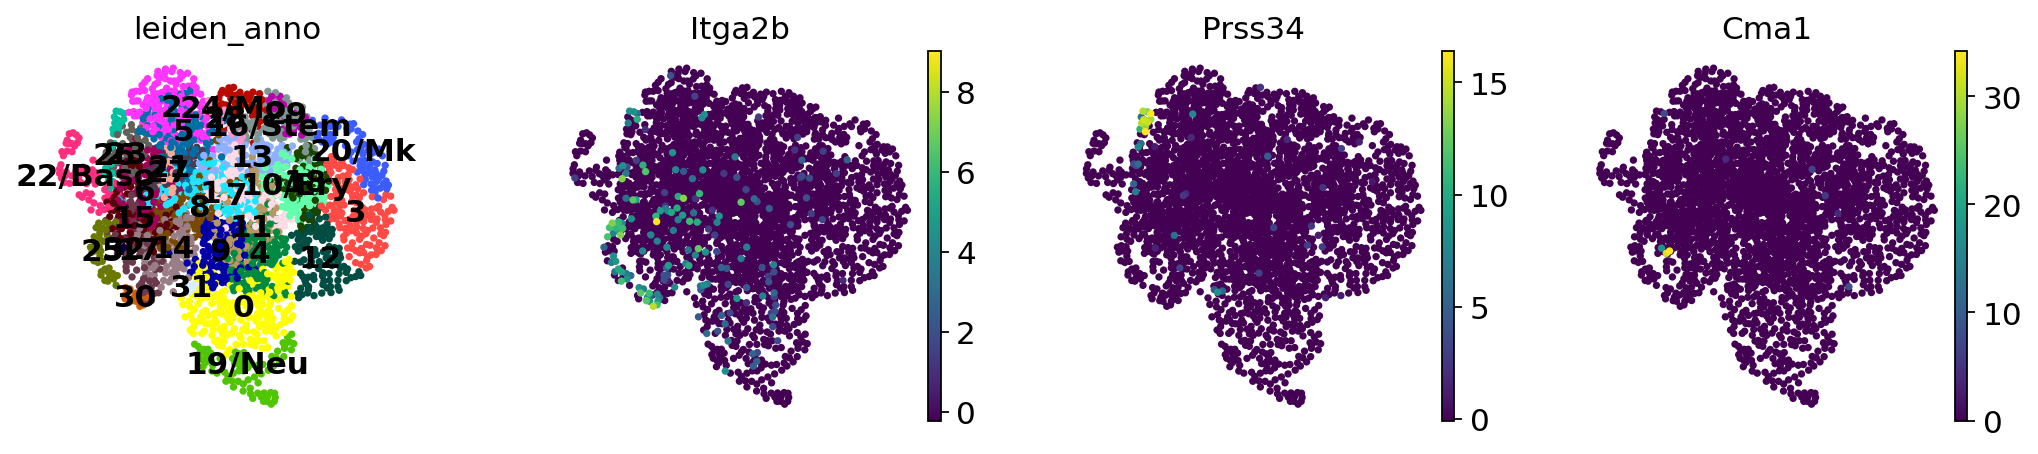

In [32]:
sc.pl.draw_graph(
    adata, color=["leiden_anno", "Itga2b", "Prss34", "Cma1"], legend_loc="on data"
)

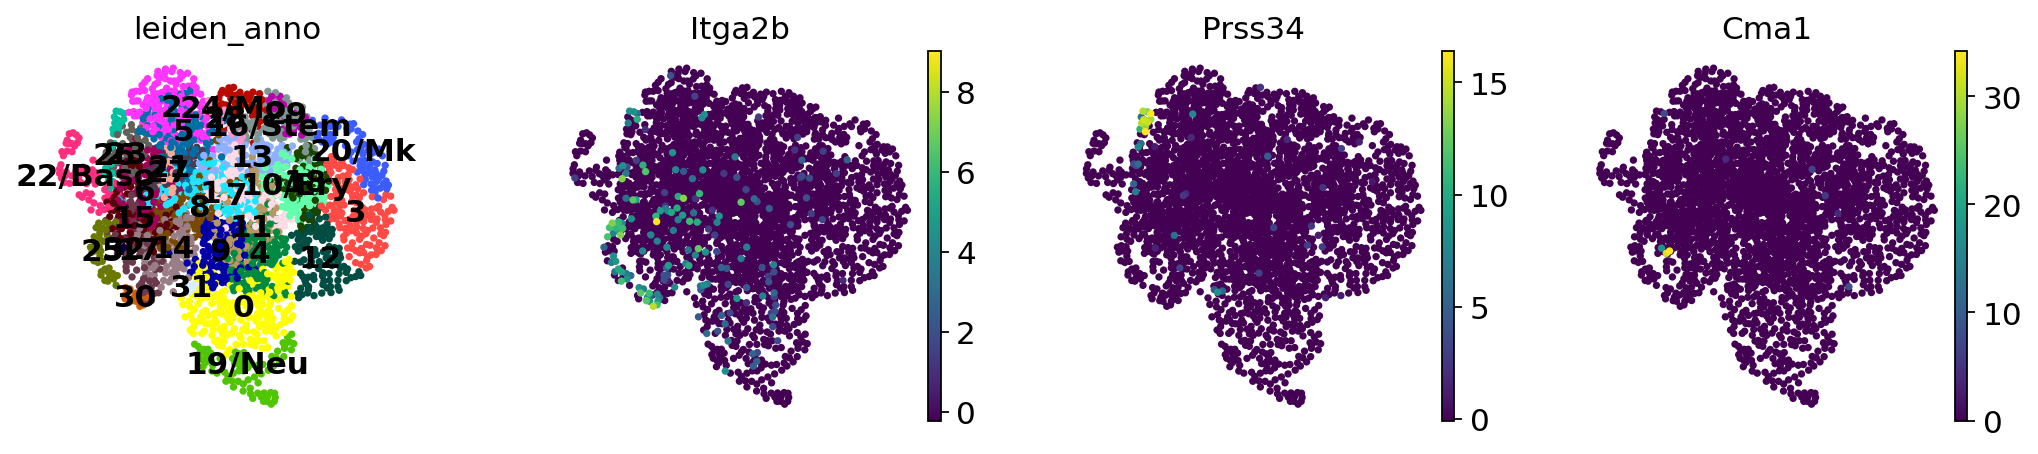

In [33]:
sc.pl.draw_graph(
    adata, color=["leiden_anno", "Itga2b", "Prss34", "Cma1"], legend_loc="on data"
)

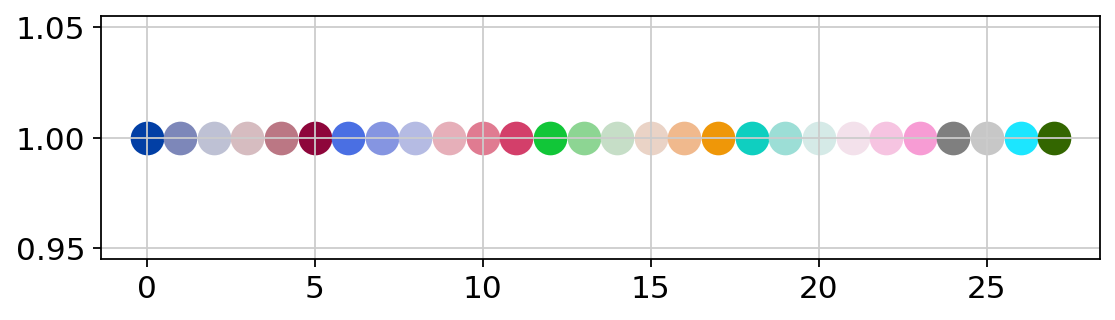

In [34]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [35]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns["leiden_anno_colors"])

In [36]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[  # Ery colors / red
    [5, 5, 5, 5, 11, 11, 10, 9, 21, 21]
]
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [37]:
adata.uns["leiden_anno_colors"] = new_colors

--> added 'pos', the PAGA positions (adata.uns['paga'])


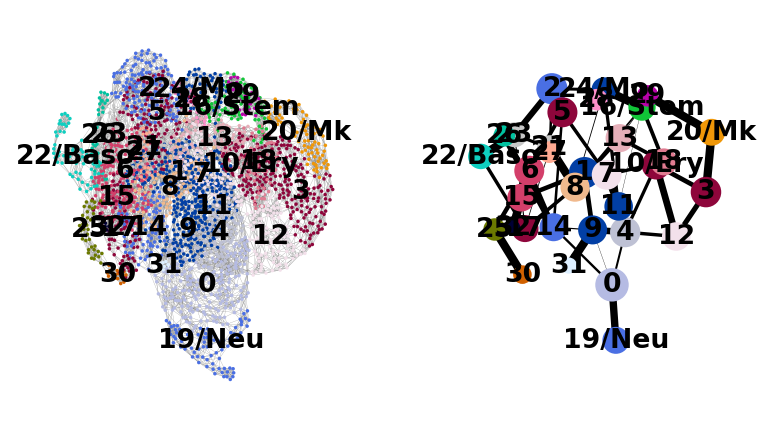

[<Axes: xlabel='FR1', ylabel='FR2'>, <Axes: >]

In [38]:
sc.pl.paga_compare(
    adata,
    threshold=0.03,
    title="",
    right_margin=0.2,
    size=10,
    edge_width_scale=0.5,
    legend_fontsize=12,
    fontsize=12,
    frameon=False,
    edges=True,
    save=True,
)

### Reconstructing gene changes along PAGA paths for a given set of genes

In [39]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["leiden_anno"] == "16/Stem")[0]

In [40]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [41]:
gene_names = [
    *["Gata2", "Gata1", "Klf1", "Epor", "Hba-a2"],  # erythroid
    *["Elane", "Cebpe", "Gfi1"],  # neutrophil
    *["Irf8", "Csf1r", "Ctsg"],  # monocyte
]

In [42]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

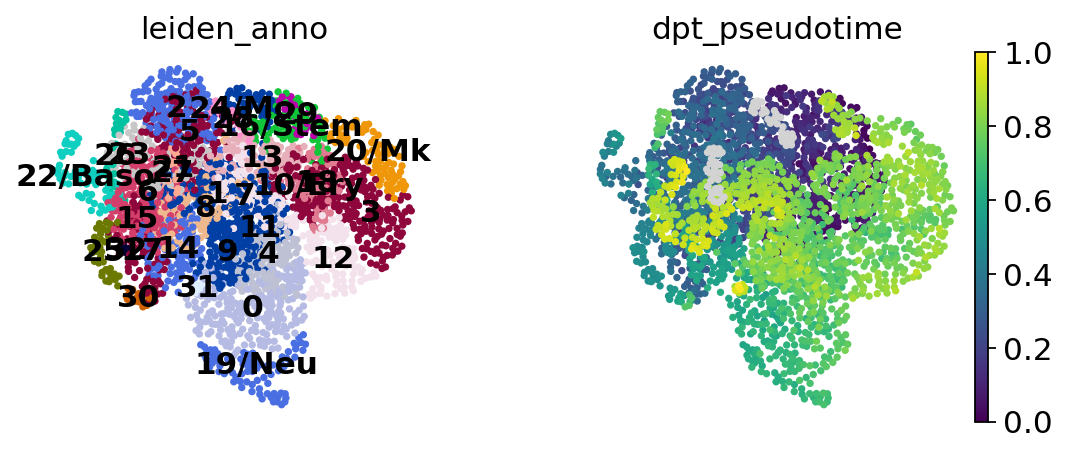

In [44]:
sc.pl.draw_graph(adata, color=["leiden_anno", "dpt_pseudotime"], legend_loc="on data")

In [45]:
paths = [
    ("erythrocytes", [16, 12, 7, 13, 18, 6, 5, 10]),
    ("neutrophils", [16, 0, 4, 2, 14, 19]),
    ("monocytes", [16, 0, 4, 11, 1, 9, 24]),
]

In [46]:
adata.obs["distance"] = adata.obs["dpt_pseudotime"]

In [47]:
adata.obs["clusters"] = adata.obs["leiden_anno"]  # just a cosmetic change

In [48]:
adata.uns["clusters_colors"] = adata.uns["leiden_anno_colors"]

In [49]:
!mkdir write

/usr/local/lib/python3.12/dist-packages/scanpy/plotting/_tools/paga.py:1292: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/usr/local/lib/python3.12/dist-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


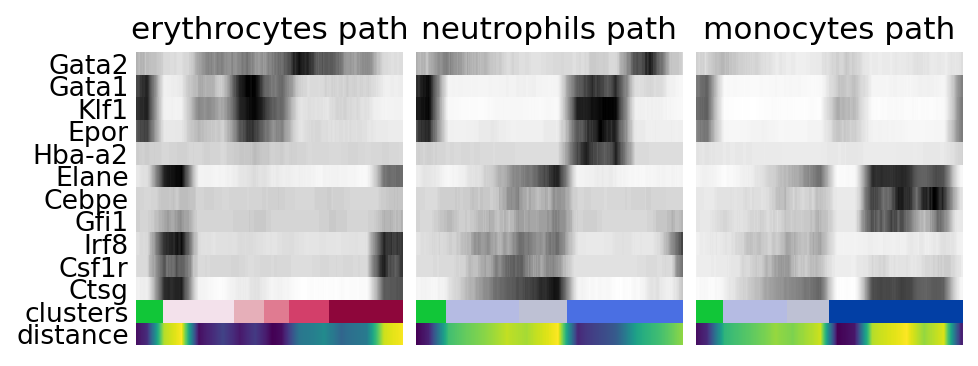

In [50]:
_, axs = pl.subplots(
    ncols=3, figsize=(6, 2.5), gridspec_kw={"wspace": 0.05, "left": 0.12}
)
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    data = sc.pl.paga_path(
        adata,
        path,
        gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["distance"],
        show_yticks=True if ipath == 0 else False,
        show_colorbar=False,
        color_map="Greys",
        groups_key="clusters",
        color_maps_annotations={"distance": "viridis"},
        title="{} path".format(descr),
        return_data=True,
        show=False,
    )
    data.to_csv("./write/paga_path_{}.csv".format(descr))
pl.savefig("./figures/paga_path_paul15.pdf")
pl.show()